In [3]:
from utils import utils
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t, norm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

alerts = utils.get_data()
alerts.filter_by_group_time(120, True)

hourly_accident = utils.hourly_group(alerts.data[alerts.data["type"] == "ACCIDENT"])
hourly_jam = utils.hourly_group(alerts.data[alerts.data["type"] == "JAM"])

In [ ]:

alerts.data.pub_millis.max()

In [4]:
linear_model = LinearRegression()

# Join the three DataFrames on the 'hour' index
dat = hourly_accident.join(hourly_jam, lsuffix="_accident", rsuffix="_jam")

dat

day_type,hour_accident,f_accident,s_accident,hour_jam,f_jam,s_jam
0,0,0.066667,0.100000,0,0.069124,0.064516
1,1,0.077778,0.083333,1,0.119816,0.036866
2,2,0.122222,0.033333,2,0.032258,0.036866
3,3,0.100000,0.050000,3,0.059908,0.046083
4,4,0.100000,0.027778,4,0.004608,0.023041
5,5,0.100000,0.033333,5,0.018433,0.036866
6,6,0.105556,0.172222,6,0.032258,0.566820
7,7,0.100000,1.777778,7,0.036866,18.580645
8,8,0.100000,1.300000,8,0.096774,12.050691
9,9,0.105556,0.511111,9,0.179724,2.617512


In [5]:
dat = dat[["s_accident", "s_jam"]]

# Fill missing values with 0
dat = dat.fillna(0)

# Create the feature matrix X
X = dat[["s_jam"]].values

# Create the target vector y
y = dat["s_accident"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

y_pred

array([0.47887921, 0.43766157, 0.23059198, 0.54364979, 0.53040127])

In [6]:
from sklearn.metrics import root_mean_squared_error, r2_score

print(f"Coeficiente de determinación: {r2_score(y_test, y_pred)}")
print(f"Error cuadrático medio: {root_mean_squared_error(y_test, y_pred)}")

Coeficiente de determinación: 0.3811861940273368
Error cuadrático medio: 0.09789387288435186


In [7]:
import statsmodels.formula.api as smf

linear_model = smf.ols(data=dat, formula="s_accident ~ s_jam")
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             s_accident   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     256.3
Date:                Sat, 10 May 2025   Prob (F-statistic):           1.32e-13
Time:                        15:10:50   Log-Likelihood:                 11.021
No. Observations:                  24   AIC:                            -18.04
Df Residuals:                      22   BIC:                            -15.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1824      0.042      4.296      0.0

In [8]:
results.params

Intercept    0.182365
s_jam        0.105443
dtype: float64

In [9]:
1 / results.params["s_jam"]  # Proporción congestión / accidentes

np.float64(9.483786835488884)

In [10]:
dat.sum()

day_type
s_accident    14.827778
s_jam         99.115207
dtype: float64

In [11]:
dat.sum().loc["s_accident"] / dat.sum().loc["s_jam"]

np.float64(0.14960144029095118)

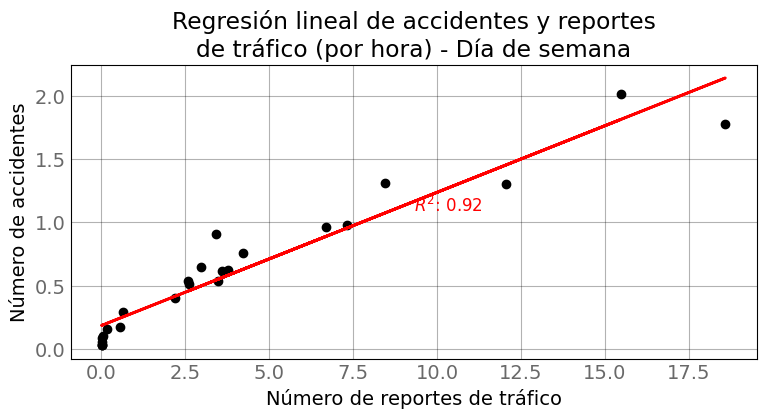

In [12]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(15, 5))

# Graficar los datos originales
plt.scatter(dat["s_jam"], dat["s_accident"], color="black", label="Datos")

# Graficar la línea de regresión
plt.plot(
    dat["s_jam"],
    results.params["Intercept"] + results.params["s_jam"] * dat["s_jam"],
    color="red",
    linewidth=2,
    label="Linea de ajuste",
)

plt.title("Regresión lineal de accidentes y reportes\nde tráfico (por hora) - Día de semana")
plt.text(0.5, 0.5, rf"$R^2$: {results.rsquared:.2f}", transform=plt.gca().transAxes, fontsize=12, color="red")
plt.xlabel("Número de reportes de tráfico")
plt.ylabel("Número de accidentes")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("thesis/images/corr_lin_ds.png")
plt.show()

### Prueba de hipótesis de correlación de Pearson

Fuente: Montgomery

La correlación de Pearson es una medida de la relación lineal entre dos variables aleatorias. Es un valor entre -1 y 1, donde:

- 1 indica una correlación positiva perfecta
- -1 indica una correlación negativa perfecta
- 0 indica que no hay correlación

La hipótesis nula de la prueba de correlación de Pearson es que no hay correlación entre las dos variables. La hipótesis alternativa es que hay una correlación entre las dos variables.

La prueba de correlación de Pearson se puede realizar en Python utilizando la función `pearsonr` de la biblioteca `scipy.stats`.

```python
from scipy.stats import pearsonr

# Datos de ejemplo
data1 = [0.1, 0.2, 0.3, 0.4, 0.5]
data2 = [0.5, 0.4, 0.3, 0.2, 0.1]

# Prueba de correlación de Pearson
corr, p_value = pearsonr(data1, data2)

print('Coeficiente de correlación de Pearson:', corr)
print('Valor p:', p_value)
```

En este ejemplo, `data1` y `data2` son dos listas de datos. La función `pearsonr` devuelve el coeficiente de correlación de Pearson y el valor p asociado con la prueba de hipótesis.

### Prueba de hipótesis de correlación con estadístico T

Otra forma de realizar una prueba de correlación es utilizando el estadístico T. La fórmula para el estadístico T es:

$$
t = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}
$$

Donde $r$ es el coeficiente de correlación de Pearson y $n$ es el número de observaciones.

Para realizar una prueba de hipótesis de correlación con el estadístico T, se compara el valor calculado de $t$ con el valor crítico de la distribución t de Student con $n-2$ grados de libertad.

```python
from scipy.stats import t

# Datos de ejemplo
data1 = [0.1, 0.2, 0.3, 0.4, 0.5]
data2 = [0.5, 0.4, 0.3, 0.2, 0.1]

# Prueba de correlación con estadístico T
corr, p_value = pearsonr(data1, data2)
t_stat = corr * ((len(data1) - 2) ** 0.5) / ((1 - corr ** 2) ** 0.5)
p_value = 2 * (1 - t.cdf(abs(t_stat), len(data1) - 2))

print('Estadístico T:', t_stat)
print('Valor p:', p_value)
```

En este ejemplo, se calcula el estadístico T y el valor p asociado con la prueba de hipótesis de correlación utilizando el estadístico T.

Ambos métodos son válidos para realizar una prueba de correlación de Pearson en Python. La función `pearsonr` es más sencilla de usar, mientras que el cálculo manual del estadístico T proporciona una mayor comprensión de la prueba de hipótesis.

In [13]:
r, p_value = pearsonr(dat.s_jam, dat.s_accident)

r, p_value

(np.float64(0.959659017272869), np.float64(1.316237352009788e-13))

In [14]:
n = dat.s_jam.shape[0]

T = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
T

np.float64(16.009021832846148)

In [15]:
alpha = 0.01

t_param = -t.ppf(alpha / 2, n - 2)

t_param

np.float64(2.073873067904015)

Dado que T < valor crítico de la distribución t de Student con n - 2 grados de libertad, rechazamos la hipótesis nula y concluimos que hay una correlación entre las dos variables. Además, el valor p es menor que 0.05, lo que confirma la significancia estadística de la correlación.

Validación con transformación de Fisher

$$
Z = \frac{1}{2} \ln\left( \frac{1 + r}{1 - r} \right)
$$

El error estándar asociado a Z se calcula con la siguiente fórmula:

$$
SE_Z = \frac{1}{\sqrt{n - 3}}
$$

In [16]:
Z = 1 / 2 * np.log((1 + r) / (1 - r))
SEz = 1 / np.sqrt(n - 3)
z_param = -norm.ppf(alpha / 2)
ic = [Z - z_param * SEz, Z + z_param * SEz]

ic

[np.float64(1.513879730841417), np.float64(2.3692781421311366)]

Inversa de Fisher Z para obtener el intervalo de confianza en términos de r:

$$
r = \frac{e^{2Z} - 1}{e^{2Z} + 1}
$$

In [17]:
ic_r = [(np.exp(2 * ic[0]) - 1) / (np.exp(2 * ic[0]) + 1), (np.exp(2 * ic[1]) - 1) / (np.exp(2 * ic[1]) + 1)]
ic_r

[np.float64(0.907625136492211), np.float64(0.9826492978677942)]

In [18]:
np.power(ic_r, 2)

array([0.82378339, 0.96559964])

### Fin de semana / Feriados

In [19]:

dat_f = hourly_accident.join(hourly_jam, lsuffix="_accident", rsuffix="_jam")
dat_f = dat_f[["f_accident", "f_jam"]]

# Fill missing values with 0
dat_f = dat_f.fillna(0)


linear_model = smf.ols(data=dat_f, formula="f_accident ~ f_jam")
results_f = linear_model.fit()
print(results_f.summary())

                            OLS Regression Results                            
Dep. Variable:             f_accident   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     27.74
Date:                Sat, 10 May 2025   Prob (F-statistic):           2.77e-05
Time:                        15:10:50   Log-Likelihood:                 37.372
No. Observations:                  24   AIC:                            -70.74
Df Residuals:                      22   BIC:                            -68.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1078      0.015      6.968      0.0

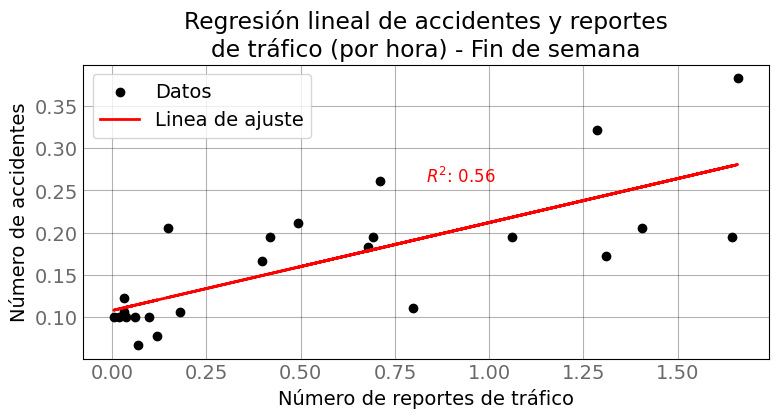

In [20]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(15, 5))

# Graficar los datos originales
plt.scatter(dat_f["f_jam"], dat_f["f_accident"], color="black", label="Datos")

# Graficar la línea de regresión
plt.plot(
    dat_f["f_jam"],
    results_f.params["Intercept"] + results_f.params["f_jam"] * dat_f["f_jam"],
    color="red",
    linewidth=2,
    label="Linea de ajuste",
)

plt.title("Regresión lineal de accidentes y reportes\nde tráfico (por hora) - Fin de semana")
plt.text(0.5, 0.6, rf"$R^2$: {results_f.rsquared:.2f}", transform=plt.gca().transAxes, fontsize=12, color="red")
plt.xlabel("Número de reportes de tráfico")
plt.ylabel("Número de accidentes")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("thesis/images/corr_lin_fs.png")
plt.show()

In [21]:
hourly_accident.sum(), "----", hourly_jam.sum()

(day_type
 hour    276.000000
 f         3.977778
 s        14.827778
 dtype: float64,
 '----',
 day_type
 hour    276.000000
 f        13.345622
 s        99.115207
 dtype: float64)

In [22]:
hourly_accident.sum()["f"] / 2

np.float64(1.988888888888889)

In [23]:
hourly_accident.sum()["s"] / 5

np.float64(2.9655555555555555)

Modelo exponencial inverso:
$$
y = \frac{a}{x^b}
$$


## Prueba otros modelos

In [24]:
from scipy.optimize import curve_fit


def inverse_exp(x, a, b):
    return a / np.power(x, b)

In [25]:
params, covariance = curve_fit(inverse_exp, dat["s_jam"], dat["s_accident"])

params, covariance

(array([ 0.29624876, -0.64147247]),
 array([[0.00078126, 0.00107829],
        [0.00107829, 0.00163694]]))

In [26]:
mse_s = np.sum((dat["s_accident"] - inverse_exp(dat["s_jam"], *params)) ** 2)
mst_s = np.sum((dat["s_accident"] - np.mean(dat["s_accident"])) ** 2)

r2_s = 1 - mse_s / mst_s

r2_s

np.float64(0.9599536944285567)

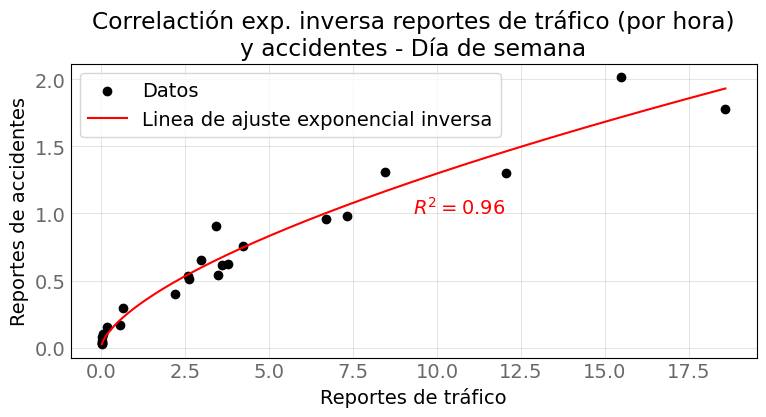

In [27]:
plt.figure(figsize=(15, 5))
plt.scatter(dat["s_jam"], dat["s_accident"], label="Datos", color="black")

x_fit = np.linspace(dat["s_jam"].min(), dat["s_jam"].max(), 1000)
y_fit = inverse_exp(x_fit, *params)

plt.plot(x_fit, y_fit, "r-", label="Linea de ajuste exponencial inversa")
plt.text(
    (dat["s_jam"].max() - dat["s_jam"].min()) / 2,
    (dat["s_accident"].max() - dat["s_accident"].min()) / 2,
    rf"$R^2={r2_s:.2f}$",
    color="r",
    fontweight="bold",
)

plt.xlabel("Reportes de tráfico")
plt.ylabel("Reportes de accidentes")
plt.title("Correlación exp. inversa reportes de tráfico (por hora)\ny accidentes - Día de semana")
plt.tight_layout()
plt.savefig("thesis/images/corr_exp_ds.png")
plt.show()

In [28]:
params_f, covariance_f = curve_fit(inverse_exp, dat_f["f_jam"], dat_f["f_accident"])

mse_f = np.sum((dat_f["f_accident"] - inverse_exp(dat_f["f_jam"], *params_f)) ** 2)
mst_f = np.sum((dat_f["f_accident"] - np.mean(dat_f["f_accident"])) ** 2)

r2_f = 1 - mse_f / mst_f

r2_f

np.float64(0.5492845586603289)

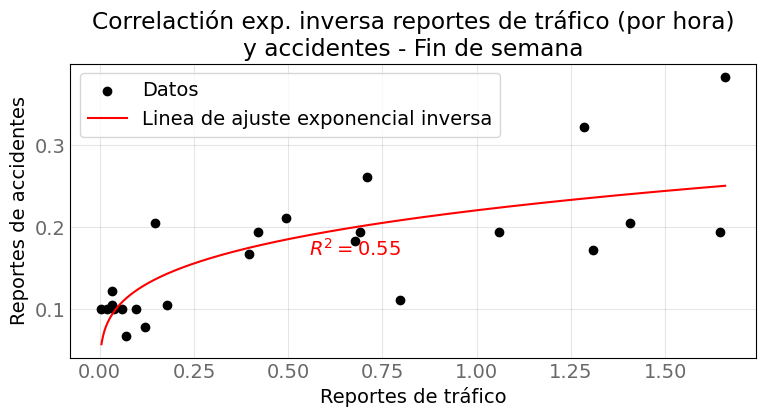

In [29]:

plt.figure(figsize=(15, 5))
plt.scatter(dat_f["f_jam"], dat_f["f_accident"], label="Datos", color="black")

x_fit_f = np.linspace(dat_f["f_jam"].min(), dat_f["f_jam"].max(), 1000)
y_fit_f = inverse_exp(x_fit_f, *params_f)

plt.plot(x_fit_f, y_fit_f, "r-", label="Linea de ajuste exponencial inversa")
plt.text(dat_f["f_jam"].mean(), dat_f["f_accident"].mean(), rf"$R^2={r2_f:.2f}$", color="r", fontweight="bold")

plt.title("Correlación exp. inversa reportes de tráfico (por hora)\ny accidentes - Fin de semana")
plt.xlabel("Reportes de tráfico")
plt.ylabel("Reportes de accidentes")
plt.tight_layout()
plt.savefig("thesis/images/corr_exp_fs.png")
plt.show()

In [ ]:
#
from scipy import stats


#
def test_inverse_exponential_fit(x_data, y_data, params, alpha=0.05):
    """
    Realiza prueba de hipótesis para el modelo exponencial inverso y = a/x^b

    Args:
        x_data: Variable independiente (jam)
        y_data: Variable dependiente (accident)
        params: Parámetros estimados [a, b]
        alpha: Nivel de significancia

    Returns:
        Dictionary con resultados de la prueba
    """
    # Número de observaciones y parámetros
    n = len(x_data)
    p = len(params)

    # Grados de libertad
    df = n - p

    # Valores predichos
    y_pred = inverse_exp(x_data, *params)

    # Residuos
    residuals = y_data - y_pred

    # Suma de cuadrados de residuos
    sse = np.sum(residuals**2)

    # Error estándar de estimación
    se = np.sqrt(sse / df)

    # Matriz jacobiana (derivadas parciales)
    def jac(x, a, b):
        # Derivada respecto a 'a': 1/x^b
        da = 1 / np.power(x, b)
        # Derivada respecto a 'b': -a * ln(x) / x^b
        db = -a * np.log(x) / np.power(x, b)
        return np.vstack([da, db]).T

    # Calcular la matriz jacobiana en los puntos observados
    J = jac(x_data, *params)

    # Matriz de covarianza de los parámetros (aproximación)
    # (J^T J)^(-1) * s^2
    JTJ_inv = np.linalg.inv(J.T @ J)
    cov_matrix = JTJ_inv * (sse / df)

    # Errores estándar de los parámetros
    se_params = np.sqrt(np.diag(cov_matrix))

    # Estadístico t para cada parámetro
    t_stats = params / se_params

    # Valores p (prueba de dos colas)
    p_values = [2 * (1 - stats.t.cdf(abs(t), df)) for t in t_stats]

    # Intervalos de confianza
    t_crit = stats.t.ppf(1 - alpha / 2, df)
    ci_lower = params - t_crit * se_params
    ci_upper = params + t_crit * se_params

    # F-test para la significancia global del modelo
    # H0: a=b=0 (modelo nulo)
    mst = np.sum((y_data - np.mean(y_data)) ** 2)
    msr = mst - sse
    f_stat = (msr / p) / (sse / df)
    f_pvalue = 1 - stats.f.cdf(f_stat, p, df)

    # R-cuadrado
    r_squared = 1 - (sse / mst)
    # R-cuadrado ajustado
    r_squared_adj = 1 - ((1 - r_squared) * (n - 1) / df)

    # Resultados
    results = {
        "params": params,
        "se": se_params,
        "t_stats": t_stats,
        "p_values": p_values,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
        "r_squared": r_squared,
        "r_squared_adj": r_squared_adj,
        "f_stat": f_stat,
        "f_pvalue": f_pvalue,
        "residual_se": se,
        "df": df,
    }

    return results


# Ejecutar la prueba para los datos de día de semana
s_results = test_inverse_exponential_fit(dat["s_jam"].values, dat["s_accident"].values, params)

# Imprimir resumen de resultados
print("\n" + "=" * 50)
print("PRUEBA DE HIPÓTESIS - MODELO EXPONENCIAL INVERSO")
print("DÍAS DE SEMANA")
print("=" * 50)
print(f"Modelo: y = a/x^b donde a = {params[0]:.4f}, b = {params[1]:.4f}")
print(f"\nR²: {s_results['r_squared']:.4f}")
print(f"R² ajustado: {s_results['r_squared_adj']:.4f}")
print("\nPrueba de significancia de parámetros:")
print(f"Parámetro a: t = {s_results['t_stats'][0]:.4f}, p-valor = {s_results['p_values'][0]:.6f}")
print(f"    IC 95%: [{s_results['ci_lower'][0]:.4f}, {s_results['ci_upper'][0]:.4f}]")
print(f"Parámetro b: t = {s_results['t_stats'][1]:.4f}, p-valor = {s_results['p_values'][1]:.6f}")
print(f"    IC 95%: [{s_results['ci_lower'][1]:.4f}, {s_results['ci_upper'][1]:.4f}]")
print("\nPrueba F para significancia global del modelo:")
print(f"F({s_results['params'].size}, {s_results['df']}): {s_results['f_stat']:.4f}")
print(f"p-valor: {s_results['f_pvalue']:.6f}")

# Conclusión de la prueba de hipótesis
alpha = 0.05
print("\nConclusiones:")
if s_results["f_pvalue"] < alpha:
    print(f"- El modelo es estadísticamente significativo (p < {alpha})")
else:
    print(f"- No hay suficiente evidencia para afirmar que el modelo es significativo (p > {alpha})")

for i, p_val in enumerate(s_results["p_values"]):
    param_name = "a" if i == 0 else "b"
    if p_val < alpha:
        print(f"- El parámetro {param_name} es estadísticamente significativo (p < {alpha})")
    else:
        print(
            f"- No hay suficiente evidencia para afirmar que el parámetro {param_name} es significativo (p > {alpha})"
        )

# Repetir para los datos de fin de semana
f_results = test_inverse_exponential_fit(dat_f["f_jam"].values, dat_f["f_accident"].values, params_f)

print("\n" + "=" * 50)
print("PRUEBA DE HIPÓTESIS - MODELO EXPONENCIAL INVERSO")
print("FIN DE SEMANA")
print("=" * 50)
print(f"Modelo: y = a/x^b donde a = {params_f[0]:.4f}, b = {params_f[1]:.4f}")
print(f"\nR²: {f_results['r_squared']:.4f}")
print(f"R² ajustado: {f_results['r_squared_adj']:.4f}")
print("\nPrueba de significancia de parámetros:")
print(f"Parámetro a: t = {f_results['t_stats'][0]:.4f}, p-valor = {f_results['p_values'][0]:.6f}")
print(f"    IC 95%: [{f_results['ci_lower'][0]:.4f}, {f_results['ci_upper'][0]:.4f}]")
print(f"Parámetro b: t = {f_results['t_stats'][1]:.4f}, p-valor = {f_results['p_values'][1]:.6f}")
print(f"    IC 95%: [{f_results['ci_lower'][1]:.4f}, {f_results['ci_upper'][1]:.4f}]")
print("\nPrueba F para significancia global del modelo:")
print(f"F({f_results['params'].size}, {f_results['df']}): {f_results['f_stat']:.4f}")
print(f"p-valor: {f_results['f_pvalue']:.6f}")

# Conclusión de la prueba de hipótesis para fin de semana
print("\nConclusiones:")
if f_results["f_pvalue"] < alpha:
    print(f"- El modelo es estadísticamente significativo (p < {alpha})")
else:
    print(f"- No hay suficiente evidencia para afirmar que el modelo es significativo (p > {alpha})")

for i, p_val in enumerate(f_results["p_values"]):
    param_name = "a" if i == 0 else "b"
    if p_val < alpha:
        print(f"- El parámetro {param_name} es estadísticamente significativo (p < {alpha})")
    else:
        print(
            f"- No hay suficiente evidencia para afirmar que el parámetro {param_name} es significativo (p > {alpha})"
        )

# Gráfico de diagnóstico para los residuos
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    inverse_exp(dat["s_jam"].values, *params),
    dat["s_accident"].values - inverse_exp(dat["s_jam"].values, *params),
    alpha=0.7,
)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Días de semana")

plt.subplot(1, 2, 2)
plt.scatter(
    inverse_exp(dat_f["f_jam"].values, *params_f),
    dat_f["f_accident"].values - inverse_exp(dat_f["f_jam"].values, *params_f),
    alpha=0.7,
)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Fin de semana")

plt.tight_layout()
plt.savefig("thesis/images/residuos_exp.png")
plt.show()

# QQ Plot para verificar normalidad de residuos
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
stats.probplot(dat["s_accident"].values - inverse_exp(dat["s_jam"].values, *params), plot=plt)
plt.title("QQ Plot - Días de semana")

plt.subplot(1, 2, 2)
stats.probplot(dat_f["f_accident"].values - inverse_exp(dat_f["f_jam"].values, *params_f), plot=plt)
plt.title("QQ Plot - Fin de semana")

plt.tight_layout()
plt.savefig("thesis/images/qq_exp.png")
plt.show()

In [ ]:


def test_linear_model(x_data, y_data, results, alpha=0.05):
    """
    Realiza prueba de hipótesis para el modelo lineal y = mx + b

    Args:
        x_data: Variable independiente (jam)
        y_data: Variable dependiente (accident)
        results: Resultados del modelo de regresión lineal (statsmodels)
        alpha: Nivel de significancia

    Returns:
        Dictionary con resultados de la prueba
    """
    # Número de observaciones y parámetros
    n = len(x_data)
    p = len(results.params)

    # Grados de libertad
    df = n - p

    # Valores predichos
    y_pred = results.predict()

    # Residuos
    residuals = y_data - y_pred

    # Suma de cuadrados de residuos
    sse = np.sum(residuals**2)

    # Error estándar de estimación
    se = np.sqrt(sse / df)

    # Errores estándar de los parámetros
    se_params = results.bse

    # Estadístico t para cada parámetro
    t_stats = results.tvalues

    # Valores p (prueba de dos colas)
    p_values = results.pvalues

    # Intervalos de confianza
    ci = results.conf_int(alpha=alpha)
    ci_lower = ci[0]  # Corregido para acceder a los valores correctamente
    ci_upper = ci[1]  # Corregido para acceder a los valores correctamente

    # F-test para la significancia global del modelo
    f_stat = results.fvalue
    f_pvalue = results.f_pvalue

    # R-cuadrado
    r_squared = results.rsquared
    # R-cuadrado ajustado
    r_squared_adj = results.rsquared_adj

    # Coeficiente de correlación de Pearson
    pearson_r, pearson_p = stats.pearsonr(x_data, y_data)

    # Estadístico T para prueba de correlación
    t_stat = pearson_r * np.sqrt(n - 2) / np.sqrt(1 - pearson_r**2)
    t_pvalue = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))

    # Transformación de Fisher para intervalo de confianza del coeficiente de correlación
    z = 0.5 * np.log((1 + pearson_r) / (1 - pearson_r))
    se_z = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    ci_z_lower = z - z_crit * se_z
    ci_z_upper = z + z_crit * se_z

    # Transformación inversa para obtener el intervalo de confianza en términos de r
    ci_r_lower = (np.exp(2 * ci_z_lower) - 1) / (np.exp(2 * ci_z_lower) + 1)
    ci_r_upper = (np.exp(2 * ci_z_upper) - 1) / (np.exp(2 * ci_z_upper) + 1)

    # Resultados
    test_results = {
        "params": results.params,
        "se": se_params,
        "t_stats": t_stats,
        "p_values": p_values,
        'ci_lower': ci[0],  # Accedemos a la primera columna del DataFrame
        'ci_upper': ci[1],  # Accedemos a la segunda columna del DataFrame
        "r_squared": r_squared,
        "r_squared_adj": r_squared_adj,
        "f_stat": f_stat,
        "f_pvalue": f_pvalue,
        "residual_se": se,
        "df": df,
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "t_stat_corr": t_stat,
        "t_pvalue_corr": t_pvalue,
        "ci_r_lower": ci_r_lower,
        "ci_r_upper": ci_r_upper,
    }

    return test_results


# Ejecutar pruebas estadísticas para días de semana
s_test_results = test_linear_model(dat["s_jam"], dat["s_accident"], results)

# Imprimir resultados para días de semana
print("\n" + "=" * 50)
print("PRUEBA DE HIPÓTESIS - MODELO LINEAL")
print("DÍAS DE SEMANA")
print("=" * 50)
print(f"Modelo: y = {s_test_results['params']['s_jam']:.4f}x + {s_test_results['params']['Intercept']:.4f}")
print(f"\nR²: {s_test_results['r_squared']:.4f}")
print(f"R² ajustado: {s_test_results['r_squared_adj']:.4f}")
print(f"Coeficiente de correlación de Pearson: {s_test_results['pearson_r']:.4f}")
print(f"Intervalo de confianza (95%) para r: [{s_test_results['ci_r_lower']:.4f}, {s_test_results['ci_r_upper']:.4f}]")

print("\nPrueba de significancia de parámetros:")
print(
    f"Intercepto: t = {s_test_results['t_stats']['Intercept']:.4f}, p-valor = {s_test_results['p_values']['Intercept']:.6f}"
)
print(f"    IC 95%: [{s_test_results['ci_lower']['Intercept']:.4f}, {s_test_results['ci_upper']['Intercept']:.4f}]")
print(f"Pendiente: t = {s_test_results['t_stats']['s_jam']:.4f}, p-valor = {s_test_results['p_values']['s_jam']:.6f}")
print(f"    IC 95%: [{s_test_results['ci_lower']['s_jam']:.4f}, {s_test_results['ci_upper']['s_jam']:.4f}]")

print("\nPrueba de correlación:")
print(f"Estadístico T: {s_test_results['t_stat_corr']:.4f}")
print(f"Valor p: {s_test_results['t_pvalue_corr']:.6f}")

print("\nPrueba F para significancia global del modelo:")
print(f"F({len(s_test_results['params']) - 1}, {s_test_results['df']}): {s_test_results['f_stat']:.4f}")
print(f"p-valor: {s_test_results['f_pvalue']:.6f}")

# Conclusiones
alpha = 0.05
print("\nConclusiones:")
if s_test_results["f_pvalue"] < alpha:
    print(f"- El modelo es estadísticamente significativo (p < {alpha})")
else:
    print(f"- No hay suficiente evidencia para afirmar que el modelo es significativo (p > {alpha})")

if s_test_results["pearson_p"] < alpha:
    print(f"- Existe una correlación lineal estadísticamente significativa (p < {alpha})")
else:
    print(f"- No hay suficiente evidencia para afirmar que existe correlación lineal (p > {alpha})")

# Repetir para los datos de fin de semana
f_test_results = test_linear_model(dat_f["f_jam"], dat_f["f_accident"], results_f)

# Imprimir resultados para fines de semana
print("\n" + "=" * 50)
print("PRUEBA DE HIPÓTESIS - MODELO LINEAL")
print("FIN DE SEMANA")
print("=" * 50)
print(f"Modelo: y = {f_test_results['params']['f_jam']:.4f}x + {f_test_results['params']['Intercept']:.4f}")
print(f"\nR²: {f_test_results['r_squared']:.4f}")
print(f"R² ajustado: {f_test_results['r_squared_adj']:.4f}")
print(f"Coeficiente de correlación de Pearson: {f_test_results['pearson_r']:.4f}")
print(f"Intervalo de confianza (95%) para r: [{f_test_results['ci_r_lower']:.4f}, {f_test_results['ci_r_upper']:.4f}]")

print("\nPrueba de significancia de parámetros:")
print(
    f"Intercepto: t = {f_test_results['t_stats']['Intercept']:.4f}, p-valor = {f_test_results['p_values']['Intercept']:.6f}"
)
print(f"    IC 95%: [{f_test_results['ci_lower']['Intercept']:.4f}, {f_test_results['ci_upper']['Intercept']:.4f}]")
print(f"Pendiente: t = {f_test_results['t_stats']['f_jam']:.4f}, p-valor = {f_test_results['p_values']['f_jam']:.6f}")
print(f"    IC 95%: [{f_test_results['ci_lower']['f_jam']:.4f}, {f_test_results['ci_upper']['f_jam']:.4f}]")

print("\nPrueba de correlación:")
print(f"Estadístico T: {f_test_results['t_stat_corr']:.4f}")
print(f"Valor p: {f_test_results['t_pvalue_corr']:.6f}")

print("\nPrueba F para significancia global del modelo:")
print(f"F({len(f_test_results['params']) - 1}, {f_test_results['df']}): {f_test_results['f_stat']:.4f}")
print(f"p-valor: {f_test_results['f_pvalue']:.6f}")

# Conclusiones para fin de semana
print("\nConclusiones:")
if f_test_results["f_pvalue"] < alpha:
    print(f"- El modelo es estadísticamente significativo (p < {alpha})")
else:
    print(f"- No hay suficiente evidencia para afirmar que el modelo es significativo (p > {alpha})")

if f_test_results["pearson_p"] < alpha:
    print(f"- Existe una correlación lineal estadísticamente significativa (p < {alpha})")
else:
    print(f"- No hay suficiente evidencia para afirmar que existe correlación lineal (p > {alpha})")

# Gráficos de diagnóstico para los residuos
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(results.fittedvalues, results.resid, alpha=0.7)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos - Días de semana")

plt.subplot(1, 2, 2)
plt.scatter(results_f.fittedvalues, results_f.resid, alpha=0.7)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos - Fin de semana")

plt.tight_layout()
plt.savefig("thesis/images/residuos_lin.png")
plt.show()

# QQ Plot para verificar normalidad de residuos
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
stats.probplot(results.resid, plot=plt)
plt.title("QQ Plot - Días de semana")

plt.subplot(1, 2, 2)
stats.probplot(results_f.resid, plot=plt)
plt.title("QQ Plot - Fin de semana")

plt.tight_layout()
plt.savefig("thesis/images/qq_lin.png")
plt.show()